In [33]:
pip install gurobipy

  Obtaining dependency information for gurobipy from https://files.pythonhosted.org/packages/38/b6/93d472bb463d62dc395507d688979f6f4591ea3dc8bf774bdef0f6832a9a/gurobipy-10.0.3-cp311-cp311-macosx_10_9_universal2.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 10.7 MB/s eta 0:00:0000:010:01
Note: you may need to restart the kernel to use updated packages.


In [34]:
import numpy as np
from gurobipy import *
from scipy.spatial import distance_matrix
from scipy.spatial import ConvexHull
from numpy import random
import time
import pandas as pd

# 1. 데이터 좌표 변환

In [35]:
# data call
non_point_df = pd.read_csv('../다중회귀분석/행정동별_인구수_노인시설수.csv', index_col=False)
point_df = pd.read_csv('../다중회귀분석/행정구역별_위경도_좌표.csv', index_col=False)
point_df = point_df[["읍면동/구", "위도", "경도"]]

prefered_df = pd.merge(non_point_df, point_df, left_on="행정동명", right_on="읍면동/구", how="left")

prefered_df = prefered_df[["행정동명", "총생활인구수", "남자70세이상생활인구수", "여자70세이상생활인구수", "총노인시설수", "입소정원","위도","경도"]]

# NaN 좌표 확인
prefered_df[prefered_df['위도'] == 'NaN']

prefered_df

# 이 points를 몇 개로 추려야 함
points = prefered_df[["위도", "경도"]]
points


,위도,경도
0,37.482741,127.055737
1,37.489772,127.068952
2,37.478818,127.051637
3,37.511571,127.028461
4,37.517342,127.037213
...,...,...
426,37.592892,127.080852
427,37.605882,127.099538
428,37.606190,127.094231
429,37.601174,127.080623


# 2. MCLP 확인

In [36]:
def mclp(points,K,radius):
    """
    Solve maximum covering location problem
    Input:
        points: 수요지점 좌표 (기타 인근에 있으면 좋은 시설 좌표)
        K: 배치할 노인놀이터의 수
        radius: 반경 (노인들이 이동하기 적합한 거리)
    Return:
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        f: the optimal value of the objective function
    """
    print('  Number of points %g' % points.shape[0])
    print('  K %g' % K)
    print('  Radius %g' % radius)

    start = time.time()
    sites = np.array([list(i) for i in zip(prefered_df['위도'], prefered_df['경도'])])
    J = sites.shape[0]                                         # 입지후보지 수
    I = points.shape[0]                                        # 수요지점 수
    D = distance_matrix(points,sites)                          # 입지후보지와 수요지점 간 거리 계산
    mask1 = D<=radius
    D[mask1]=1                                                 # 수요지점별로 입지후보지의 반경 내 속하면 1, 아니면 0
    D[~mask1]=0
    # Build model
    m = Model()
    # Add variables
    x = {}
    y = {}
    for i in range(I):                                        
        y[i] = m.addVar(vtype=GRB.BINARY, name="y%d" % i)     # 모델에 수요지점 변수 추가 (변수 유형은 BINARY. 위치별 인수, 변수 이름 y+숫자)
    for j in range(J):
        x[j] = m.addVar(vtype=GRB.BINARY, name="x%d" % j)     # 입지후보지 변수 추가

    m.update()
    # Add constraints
    m.addConstr(quicksum(x[j] for j in range(J)) == K)        # 입지후보지 제약 조건 (K개)

    for i in range(I):                                        # 수요지점 제약 조건
        m.addConstr(quicksum(x[j] for j in np.where(D[i]==1)[0]) >= y[i])

    m.setObjective(quicksum(y[i] for i in range(I)),GRB.MAXIMIZE)     # 목적함수 (제약 조건 포함. 모든 수요지점 더하기)
    m.setParam('OutputFlag', 0)
    m.optimize()
    end = time.time()
    print('----- Output -----')
    print('  Running time : %s seconds' % float(end-start))
    print('  Optimal coverage points: %g' % m.objVal)
    
    solution = []
    if m.status == GRB.Status.OPTIMAL:
        for v in m.getVars():
            # print v.varName,v.x
            if v.x==1 and v.varName[0]=="x":
                solution.append(int(v.varName[1:]))
    opt_sites = sites[solution]
    return opt_sites,m.objVal


In [73]:
# opts_sites, mobjVal = mclp(points, 5, 0.0028)
opts_sites, mobjVal = mclp(points, 10, 0.005)
opts_sites = pd.DataFrame(opts_sites, columns=["경도", "위도"])
opts_sites

  Number of points 431
  K 10
  Radius 0.005
----- Output -----
  Running time : 0.028378963470458984 seconds
  Optimal coverage points: 31


,경도,위도
0,37.597845,126.911773
1,37.615157,127.020721
2,37.470615,126.936991
3,37.463147,126.903482
4,37.592932,127.065725
5,37.571125,126.959033
6,37.493580,127.146876
7,37.515169,126.854789
8,37.565142,127.021850
9,37.589799,127.079050


In [74]:
def plot_input(points):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        radius: the radius of circle
    '''
    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(8,8))
    plt.scatter(points[:,0],points[:,1],c='C0')
    ax = plt.gca()
    ax.axis('equal')
    ax.tick_params(axis='both',left=False, top=False, right=False,
                       bottom=False, labelleft=False, labeltop=False,
                       labelright=False, labelbottom=False)


In [75]:
def plot_result(points,opt_sites,radius):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        radius: the radius of circle
    '''
    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(8,8))

    if isinstance(points, pd.DataFrame):
        points = points.values
    if isinstance(opt_sites, pd.DataFrame):
        opt_sites = opt_sites.values

    plt.scatter(points[:,0],points[:,1],c='C0')
    ax = plt.gca()
    plt.scatter(opt_sites[:,0],opt_sites[:,1],c='C1',marker='+')
    for site in opt_sites:
        circle = plt.Circle(site, radius, color='C1',fill=False,lw=2)
        ax.add_artist(circle)
    ax.axis('equal')
    ax.tick_params(axis='both',left=False, top=False, right=False,
                       bottom=False, labelleft=False, labeltop=False,
                       labelright=False, labelbottom=False)

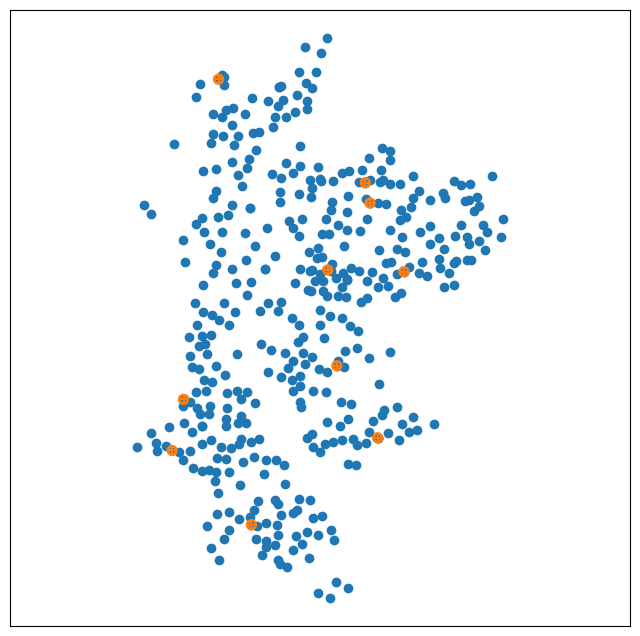

In [87]:
# plot_result(points, opts_sites, 0.0028)
plot_result(points, opts_sites, 0.0028)
